In [29]:
import numpy as np
import pandas as pd
from sublimpy import utils

from metpy.units import units
import metpy.constants

import altair as alt
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

Open data

In [30]:
# Open SOS Measurement Dataset
################################################
start_date = '20221130'
end_date = '20230509'
# open files
tidy_df = pd.read_parquet(f'../paper1/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet')

# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')

# Process one timestamp

In [31]:
one_timestamp_src = tidy_df[tidy_df.time == '2022-12-22 03:30:00']
one_timestamp_src.query("variable == 'SF_avg_1m_ue'").value.iloc[0]*units("g/m^2/s")

49.67250061035156 <Unit('gram / meter ** 2 / second')>

In [32]:
# air_temp
T = (one_timestamp_src.query("variable == 'T_2m_c'").value.iloc[0] + 273.15)*units("K")

# saturated_water_vapor_density
q_s = (
    one_timestamp_src.query("variable == 'Tsurfvaporpressure_c'").value.iloc[0]*units("pascal")*
    metpy.constants.water_molecular_weight / (
        8.314*units("J/K/mol") * (
            (one_timestamp_src.query("variable == 'T_2m_c'").value.iloc[0] + 273.15)*units("K")
        )
    )
).to_base_units()

# water_vapor_density
q = (
    one_timestamp_src.query("variable == 'vaporpressure_2m_c'").value.iloc[0]*units("pascal")*
    metpy.constants.water_molecular_weight / (
        8.314*units("J/K/mol") * (
            (one_timestamp_src.query("variable == 'T_2m_c'").value.iloc[0] + 273.15)*units("K")
        )
    )
).to_base_units()

#### Calculate particle sublimation rate, given a number of assumptions

In [33]:
r = 0.0001*units("meters")       # radius, meters - from "initial particle diameter" 
                            # from Section 2 of Sharma et al., 2018 (https://tc.copernicus.org/articles/12/3499/2018/)
lambda_s = 2838000*units("J/kg")# latent heat of sublimation (J kg−1)
k_T = 0.02288*units("W/m/K")    # thermal conductivity, for air at -10˚C  (W/m/K)
Nu = 6                          # Nusselt number, typical values for snowdrifts: 2 - 10
M_w = 0.018*units("kg/mol")     # molecular weight of water vapour (kg/mol - paper says kg, but it must be 
                            # kg/mol to cancel out the mol introduced by R)G)
R_g = 8.3145*units("J/mol/K")   # universal gas constant (J mol−1 K−1)
k_v = 24.9*1e-6*units("m^2/s")  # molecular diffusivity of h20 vapour in air (m2 s−1) - CHECK THIS FOR CORRECT T&P
Sh = Nu                         # Sherwood number 

dm_dt = (
    2*np.pi*r* (q/q_s - 1)
) / (
    (lambda_s/(k_T * T)) * (1 / Nu) * (lambda_s * M_w / (R_g * T)) + 1/(k_v * q_s * Sh)
).to_base_units()

#### Calculate particle concentration, using blowing snow flux measurements, and a few assumptions 

In [34]:
wind_speed = one_timestamp_src.query("variable == 'spd_3m_ue'").value.iloc[0] * units("m/s")
blowing_snow_flux = one_timestamp_src.query("variable == 'SF_avg_1m_ue'").value.iloc[0]*units("g/m^2/s")
blowing_snow_concentration = blowing_snow_flux / wind_speed
volume_ice_per_meter_cubed = (blowing_snow_concentration / metpy.constants.density_ice).to_base_units()
sphere_volume = (4/3)*np.pi*r**3
n_particles_per_m3 = volume_ice_per_meter_cubed / sphere_volume

In [35]:
print(blowing_snow_concentration)
print(volume_ice_per_meter_cubed)
print(sphere_volume)
print(n_particles_per_m3)

5.752228315968733 gram / meter ** 3
6.272877116650744e-06 dimensionless
4.188790204786391e-12 meter ** 3
1497539.1007845025 / meter ** 3


In [36]:
# per m^3, we have {n_particles_per_m3} particles
# those are each sublimating at a rate {dm_dt}
# total blowing snow sublimation rate occuring within a cubic meter of snow
print(dm_dt * n_particles_per_m3)
# over an hour, the following mass sublimated
print((dm_dt * n_particles_per_m3).to("kg/m^3/hr"))
# Assuming the sublimated mass is instantaneously transported vertically through a 1 m^2 face,
# i.e. integrate over the height of the cubic meter,
# we sublimated this much math per m^2
blowing_snow_sublimation_flux_kg_per_hr_m2 = (dm_dt * n_particles_per_m3).to("kg/m^3/hr")* units("m")
print(blowing_snow_sublimation_flux_kg_per_hr_m2)
# we sublimated this much SWE:
print((blowing_snow_sublimation_flux_kg_per_hr_m2 /  metpy.constants.density_water).to("mm/hr"))
# over a full day of this maximum sublimation rate, we could hypothetically sublimate:
print((blowing_snow_sublimation_flux_kg_per_hr_m2 /  metpy.constants.density_water).to("mm/day"))

-6.079096804419966e-05 kilogram / meter ** 3 / second
-0.21884748495911877 kilogram / hour / meter ** 3
-0.21884748495911877 kilogram / hour / meter ** 2
-0.21885296722594777 millimeter / hour
-5.252471213422746 millimeter / day


In [37]:
import xarray as xr
ds = xr.open_mfdataset([
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/isfs_sos_qc_geo_tiltcor_5min_20221220.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/isfs_sos_qc_geo_tiltcor_5min_20221221.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/isfs_sos_qc_geo_tiltcor_5min_20221222.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/isfs_sos_qc_geo_tiltcor_5min_20221223.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/isfs_sos_qc_geo_tiltcor_5min_20221224.nc"
])
ds = ds.compute()

In [38]:
print("latent heat fluxes measured a maximum value of:")
instant_ec_lhflux_measurement = ds['w_h2o__3m_c'].max().item() * units("g/m^2/s")
print(instant_ec_lhflux_measurement)
print("Which over an hour is")
print(instant_ec_lhflux_measurement.to("g/m^2/hr"))
print("Which over an hour is")
instant_ec_lhflux_measurement_kg_per_hr_m2 = instant_ec_lhflux_measurement.to("kg/m^2/hr")
print(instant_ec_lhflux_measurement_kg_per_hr_m2)

latent heat fluxes measured a maximum value of:
0.08826699107885361 gram / meter ** 2 / second
Which over an hour is
317.761167883873 gram / hour / meter ** 2
Which over an hour is
0.31776116788387293 kilogram / hour / meter ** 2


In [39]:
print(f"So this tells us that at the max blowing snow rate,")
print(f"when the ECs indicate a water vapor flux of {round(instant_ec_lhflux_measurement_kg_per_hr_m2, 3)}")
print(f"Our particle sublimation model estimates that {round(blowing_snow_sublimation_flux_kg_per_hr_m2, 3)} sublimated.")
print(
f"""Which accounts for {round(
    100 * blowing_snow_sublimation_flux_kg_per_hr_m2 / 
        instant_ec_lhflux_measurement_kg_per_hr_m2, 1
    ).magnitude
}% of the water vapor flux.
"""
)

So this tells us that at the max blowing snow rate,
when the ECs indicate a water vapor flux of 0.318 kilogram / hour / meter ** 2
Our particle sublimation model estimates that -0.219 kilogram / hour / meter ** 2 sublimated.
Which accounts for -68.9% of the water vapor flux.



# Process time series

In [40]:
def particle_sublimation_rate(T, q_s, q, r, lambda_s, k_T, Nu, M_w, R_g, k_v, Sh):
    dm_dt = (
        2*np.pi*r* (q/q_s - 1)
    ) / (
        (lambda_s/(k_T * T)) * (1 / Nu) * (lambda_s * M_w / (R_g * T)) + 1/(k_v * q_s * Sh)
    ).to_base_units()
    return dm_dt

In [41]:
# start and end dates for calculations
# case_study_start_date = '20221220'
# case_study_end_date = '20221224'

case_study_start_date = '20221211'
case_study_end_date = '20221215'

# parameters assumed for the particle sublimation model
r = 0.00015*units("meters")       # radius, meters - from "initial particle diameter" 
                                # from Section 2 of Sharma et al., 2018 (https://tc.copernicus.org/articles/12/3499/2018/)
lambda_s = 2838000*units("J/kg")# latent heat of sublimation (J kg−1)
k_T = 0.02288*units("W/m/K")    # thermal conductivity, for air at -10˚C  (W/m/K)
Nu = 8                          # Nusselt number, typical values for snowdrifts: 2 - 10
M_w = 0.018*units("kg/mol")     # molecular weight of water vapour (kg/mol - paper says kg, but it must be 
                            # kg/mol to cancel out the mol introduced by R)G)
R_g = 8.3145*units("J/mol/K")   # universal gas constant (J mol−1 K−1)
k_v = 24.9*1e-6*units("m^2/s")  # molecular diffusivity of h20 vapour in air (m2 s−1) - CHECK THIS FOR CORRECT T&P
Sh = Nu   

# Results list
results = []

# loop
for timestamp in tidy_df[
    (tidy_df.time >= case_study_start_date) &
    (tidy_df.time <= case_study_end_date)
].time.unique():
    tidy_src = tidy_df[tidy_df.time == timestamp]
    # air_temp
    T = (tidy_src.query("variable == 'T_2m_c'").value.iloc[0] + 273.15)*units("K")
    # saturated_water_vapor_density
    q_s = (
        tidy_src.query("variable == 'Tsurfvaporpressure_c'").value.iloc[0]*units("pascal")*
        metpy.constants.water_molecular_weight / (
            8.314*units("J/K/mol") * (
                (tidy_src.query("variable == 'T_2m_c'").value.iloc[0] + 273.15)*units("K")
            )
        )
    ).to_base_units()
    # water_vapor_density
    q = (
        tidy_src.query("variable == 'vaporpressure_2m_c'").value.iloc[0]*units("pascal")*
        metpy.constants.water_molecular_weight / (
            8.314*units("J/K/mol") * (
                (tidy_src.query("variable == 'T_2m_c'").value.iloc[0] + 273.15)*units("K")
            )
        )
    ).to_base_units()
    # get particle sublimation estimates
    sublimation = particle_sublimation_rate(T, q_s, q, r, lambda_s, k_T, Nu, M_w, R_g, k_v, Sh)
    # get particle concentration estimates
    wind_speed = tidy_src.query("variable == 'spd_3m_ue'").value.iloc[0] * units("m/s")
    blowing_snow_flux = tidy_src.query("variable == 'SF_avg_1m_ue'").value.iloc[0]*units("g/m^2/s")
    blowing_snow_concentration = blowing_snow_flux / wind_speed
    volume_ice_per_meter_cubed = (blowing_snow_concentration / metpy.constants.density_ice).to_base_units()
    sphere_volume = (4/3)*np.pi*r**3
    n_particles_per_m3 = volume_ice_per_meter_cubed / sphere_volume

    results.append((
        timestamp,
        sublimation,
        n_particles_per_m3
    ))

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>], dtype=object)

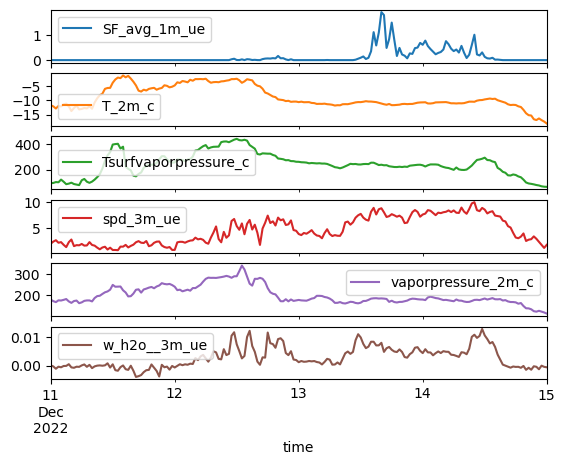

In [42]:
src = tidy_df[
    (tidy_df.time >= case_study_start_date) &
    (tidy_df.time <= case_study_end_date)
]
src = src[src.variable.isin([
    'T_2m_c',
    'Tsurfvaporpressure_c',
    'T_2m_c',
    'vaporpressure_2m_c',
    'T_2m_c',
    'spd_3m_ue',
    'SF_avg_1m_ue',
    'w_h2o__3m_ue'
])]
src = src.pivot(index='time', columns='variable', values='value')
src.plot(subplots=True)

In [43]:
df = pd.DataFrame({
    'sublimation' : list(zip(*results))[0],
    'n_particles_per_m3' : list(zip(*results))[1],
})

In [44]:
df = pd.DataFrame({
    'time' : list(zip(*results))[0],
    'sublimation' : list(zip(*results))[1],
    'n_particles_per_m3' : list(zip(*results))[2],
})
df['bs_sublimation_flux'] = (df['sublimation'] * df['n_particles_per_m3']).apply(lambda x: x.to("g/m^3/s")* units("m"))

## Compare model time steries with measured

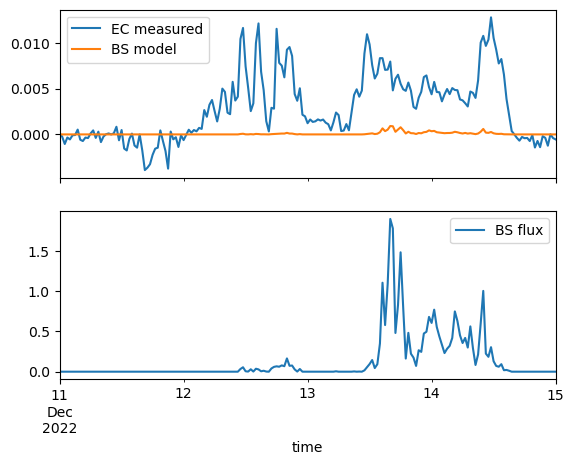

In [45]:
import matplotlib.pyplot as plt
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
src['w_h2o__3m_ue'].plot(ax=ax1, label='EC measured')
(- df.set_index('time')['bs_sublimation_flux']).apply(lambda x: x.magnitude).plot(ax=ax1, label='BS model')
src['SF_avg_1m_ue'].plot(ax=ax2, label='BS flux')
ax1.legend()
ax2.legend()

In [46]:
df_to_save = df[['time', 'bs_sublimation_flux']]
df_to_save['bs_sublimation_flux'] = -df_to_save['bs_sublimation_flux'].apply(lambda x: x.magnitude)
df_to_save.to_csv(f"bs_sublimation_{case_study_start_date}_{case_study_end_date}.csv")

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_80173/256788242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_save['bs_sublimation_flux'] = -df_to_save['bs_sublimation_flux'].apply(lambda x: x.magnitude)


# Retrieve Disdrometer data

In [47]:
import act

In [48]:
# Download and open SAIL Disdrometer data
dates = src.index.strftime('%Y-%m-%d').unique()
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

ecor_kp = 'guc30ecorS3.b1'
sebs = 'gucsebsS3.b1'
ld = 'gucldM1.b1'
output_dir = os.path.join('/Users/elischwat/Development/data/sublimationofsnow', ld)
files = []
for date in dates:
    new_files = act.discovery.download_arm_data(
        username,
        token,
        ld,
        date,
        date,
        output=output_dir
    )
    files = files + new_files
disdro_ds = xr.open_mfdataset(files)
disdro_ds = utils.modify_xarray_timezone(disdro_ds, 'UTC', 'US/Mountain')

[DOWNLOADING] gucldM1.b1.20221211.000000.cdf

If you use these data to prepare a publication, please cite:

Wang, D., Zhu, Z., & Shi, Y. Laser Disdrometer (LD). Atmospheric Radiation
Measurement (ARM) User Facility. https://doi.org/10.5439/1973058

[DOWNLOADING] gucldM1.b1.20221212.000000.cdf

If you use these data to prepare a publication, please cite:

Wang, D., Zhu, Z., & Shi, Y. Laser Disdrometer (LD). Atmospheric Radiation
Measurement (ARM) User Facility. https://doi.org/10.5439/1973058

[DOWNLOADING] gucldM1.b1.20221213.000000.cdf

If you use these data to prepare a publication, please cite:

Wang, D., Zhu, Z., & Shi, Y. Laser Disdrometer (LD). Atmospheric Radiation
Measurement (ARM) User Facility. https://doi.org/10.5439/1973058

[DOWNLOADING] gucldM1.b1.20221214.000000.cdf

If you use these data to prepare a publication, please cite:

Wang, D., Zhu, Z., & Shi, Y. Laser Disdrometer (LD). Atmospheric Radiation
Measurement (ARM) User Facility. https://doi.org/10.5439/1973058

[DOW

In [49]:
particle_size_src = disdro_ds.sel(
    time = slice("20221213 1200", "20221214 1200")
    # time = slice("20221221 1200", "20221223 0000")
)['number_density_drops'].to_dataframe()[['number_density_drops']].groupby([
    pd.Grouper(level='particle_size'),
    pd.Grouper(freq='60Min', level='time'),
]).mean().reset_index()
particle_size_src = particle_size_src[particle_size_src.particle_size < 2]
particle_size_src['hour'] = particle_size_src['time'].dt.hour
particle_size_src['time_str'] = particle_size_src['time'].dt.strftime('Dec. %d %H:00')
mode_particle_size = particle_size_src.query(
    "number_density_drops > 0"
).sort_values('number_density_drops').particle_size.iloc[-1]
(
    alt.Chart(particle_size_src).transform_calculate(
        mode = f"{mode_particle_size}"
    ).mark_rule(color='black', strokeWidth = 2).encode(
        alt.X("mode:Q")
    ) +\
    alt.Chart(
        particle_size_src
    ).mark_line().encode(
        alt.X("particle_size:Q").title("Particle diameter (mm)"),
        alt.Y("number_density_drops:Q").title("Number particles"),
        alt.Color("time:T").scale(
            scheme=alt.SchemeParams(name='yellowgreenblue', extent=[-1, 2]),
        ).legend(format = 'Dec. %d %H:00')
    ).properties(height = 100, width=200, title=f"Mode of particle size: {round(mode_particle_size, 2)}")
).configure_legend(
    gradientLength=50,
) 

alt.LayerChart(...)